# 1D Burgers Equation

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2}
\end{aligned}
$$ (eq:1dburgers)


Here, we are advised to a backwards difference for the advection term, a second order central difference for the diffusion term and a first order time stepper for the time derivative.

## Domain

In [2]:
nx = 101
xmin = 0.0
xmax = 2.0 * jnp.pi


In [3]:
Domain.Domain??

Init signature: Domain.Domain(*args, **kwargs)
Source:        
class Domain(eqx.Module):
    """Domain class for a rectangular domain

    Attributes:
        size (Tuple[int]): The size of the domain
        xmin: (Iterable[float]): The min bounds for the input domain
        xmax: (Iterable[float]): The max bounds for the input domain
        coord (List[Array]): The coordinates of the domain
        grid (Array): A grid of the domain
        ndim (int): The number of dimenions of the domain
        size (Tuple[int]): The size of each dimenions of the domain
        cell_volume (float): The total volume of a grid cell
    """

    xmin: tp.Iterable[float] = eqx.static_field()
    xmax: tp.Iterable[float] = eqx.static_field()
    dx: tp.Iterable[float] = eqx.static_field()
    Nx: tp.Iterable[int] = eqx.static_field()
    Lx: tp.Iterable[float] = eqx.static_field()
    ndim: int = eqx.static_field()

    def __init__(
        self,
        xmin: tp.Union[float, tp.Iterable[float]],
  

In [4]:
domain = Domain.init_domain_1d(xmin, xmax, nx)

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"nDims: {domain.ndim}")
print(f"Cell Volume: {domain.cell_volume}")

Nx: (101,)
Lx: (6.283185307179586,)
dx: (0.06283185307179587,)
nDims: 1
Cell Volume: 0.06283185307179587


### Initial Conditions

This probably has the most complicated initialization function I've seen in a while. It contains two functions:

$$
\begin{aligned}
u(x,t,\nu) &= - \frac{2\nu}{\phi}\frac{\partial \phi}{\partial x} + 4 \\
\phi(x,t,\nu) &= \exp\left(\frac{-(x-4t)^2}{4\nu(t+1)}\right) + \exp\left(\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{aligned}
$$

Notice that the $\boldsymbol{u}(x,t,\nu)$ has another function $\phi$ as well as its partial derivative wrt to $x$, $\partial_x\phi$.

In [5]:
import functools as ft


def phi(x, t, nu):
    denominator = 4 * nu * (t + 1)
    t1 = jnp.exp(-((x - 4 * t) ** 2) / denominator)
    t2 = jnp.exp(-((x - 4 * t - 2 * jnp.pi) ** 2) / denominator)
    return t1 + t2

In the original [tutorial](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/05_Step_4.ipynb), they used [sympy](https://www.sympy.org/en/index.html) to calculate the derivative analytically and then they created a function. I'm a bit lazy, so I will simply use autodifferentiation to calculate the gradient exactly

In [6]:
dphi_dx = jax.grad(phi, argnums=0)

Below, I use a nifty decorator to create a function that auto-vectorizes over the first argument.

In [7]:
@ft.partial(jax.vmap, in_axes=(0, None, None))
def init_u(x, t, nu):
    c = phi(x, t, nu)

    u = -((2 * nu) / c) * dphi_dx(x, t, nu) + 4

    return u

Now we can use this to initialize the Burger's function.

In [8]:
nu = 0.07
t = 0.0

u_init = init_u(domain.coords.squeeze(), 0, nu)

assert u_init.squeeze().shape == domain.coords.squeeze().shape

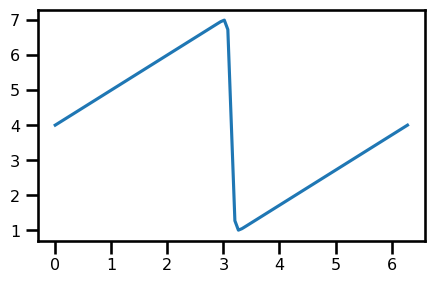

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.coords_axis[0].squeeze(), u_init)

plt.show()

### Boundary Conditions

For the boundary conditions, we will use periodic boundary conditions.

$$
\mathcal{BC}[u](x, t) = ..., \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)


In [10]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    u = u.at[0].set(u[-1])
    return u

In [11]:
u_out = bc_fn(u_init)

### Equation of Motion

Looking at the previous equation [](#eq:1dburgers) for Burgers 1D:
Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
\frac{\partial u}{\partial t} + uD^-[u] &= \nu D^2[u]
\end{aligned}
$$ (eq:1dburgers)

where $D$ is the central finite difference method.

In [16]:
from typing import Optional, Callable
from jaxsw._src.operators.functional import advection, diffusion

class Params(eqx.Module):
    bc_fn: Callable
    nu: float = eqx.static_field()
    domain: Domain.Domain = eqx.static_field()


def equation_of_motion(t: float, u: Array, params: Params):

    u = params.bc_fn(u)

    # advection 1d
    rhs_adv = advection.advection_1D(u=u, a=u, step_size=params.domain.dx)
    # rhs_adv = advection.advection_upwind_1D(u=u, a=u, step_size=domain.dx[0], accuracy=3)

    # diffusion 1D
    rhs_diff = diffusion.diffusion_1D(u=u, diffusivity=params.nu, step_size=params.domain.dx)

    return rhs_diff - rhs_adv


In [19]:
 
# SPATIAL DISCRETIZATION
u_init = init_u(domain.coords.squeeze(), 0, nu)

nu = 0.07

params = Params(bc_fn=bc_fn, nu=nu, domain=domain)

out = equation_of_motion(t=0, u=u_init, params=params)


out.min(), out.max()

(Array(-14.83436605, dtype=float64), Array(173.49642625, dtype=float64))

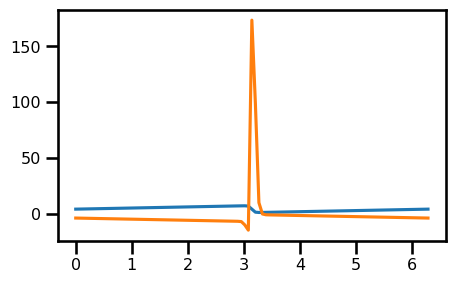

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.coords_axis[0].squeeze(), u_init)
ax.plot(domain.coords_axis[0].squeeze(), rhs)
plt.show()

## Time Stepping

In [22]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 0.5
num_save = 50

#### CFD Condition

In [28]:
# temporal parameters
c = 1.0
sigma = 0.2
nu = 0.07
dt = domain.dx[0] * nu

In [29]:
# SPATIAL DISCRETIZATION
u_init = init_u(domain.coords.squeeze(), 0, nu)


t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
# dyn_model = Burgers1D(t_domain=t_domain, saveat=saveat)

In [30]:
u_init = init_u(domain.coords.squeeze(), 0, nu)

# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.ConstantStepSize()


sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=u_init.squeeze(),
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [34]:
u_analytical = jax.vmap(init_u, in_axes=(None, 0, None))(domain.coords_axis[0], sol.ts, nu)
u_analytical.shape, sol.ys.shape, sol.ts.shape

((50, 101), (50, 101), (50,))

In [35]:
da_sol = xr.DataArray(
    data=np.asarray(sol.ys),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords_axis[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)

da_analytical = xr.DataArray(
    data=np.asarray(u_analytical),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords_axis[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)

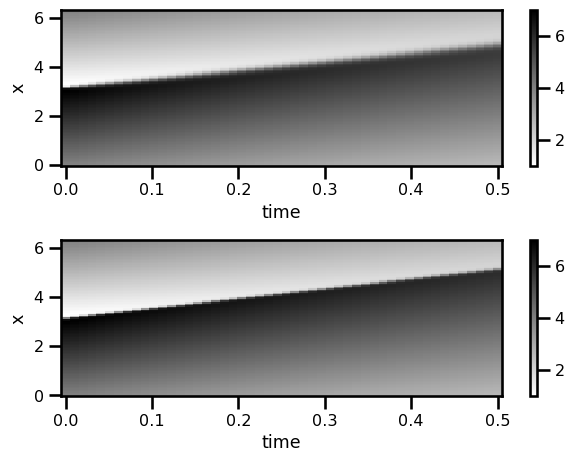

In [36]:
fig, ax = plt.subplots(nrows=2)

da_sol.T.plot.pcolormesh(ax=ax[0], cmap="gray_r")
da_analytical.T.plot.pcolormesh(ax=ax[1], cmap="gray_r")

plt.tight_layout()
plt.show()

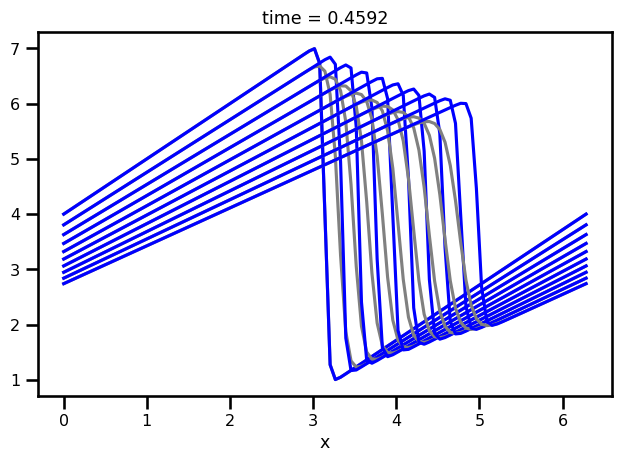

In [37]:
fig, ax = plt.subplots()

for i in range(0, len(da_sol.time), 5):
    da_sol.isel(time=i).plot.line(ax=ax, color="gray")
    da_analytical.isel(time=i).plot.line(ax=ax, color="blue")

plt.tight_layout()
plt.show()